## This notebook aims to visualize the different asset distributions produced by CGAN

Testing BondGANS

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist
import sys
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler


!pip install python-dotenv

from dotenv.main import load_dotenv
load_dotenv(override=True)
import os


In [3]:
from drive.MyDrive.MasterThesis.FashionGANOLD import ForcastGAN
from drive.MyDrive.MasterThesis.FashionGAN import FashionGAN
from drive.MyDrive.MasterThesis.BondGAN2 import BondGAN
from drive.MyDrive.MasterThesis.lambardGAN import LambardGAN
from drive.MyDrive.MasterThesis.simple_gan_portfolio import SimpleGANPortfolio
from drive.MyDrive.MasterThesis.gan_plotting import extensive_plotting

from drive.MyDrive.MasterThesis.shortrateGAN import shortRateGAN
from drive.MyDrive.MasterThesis.lambardGAN import LambardGAN

### Parameters

In [4]:
assets_0 = 1000000
liabilities_0 = 1000000 * 0.88
num_simulations = 10000
bof_0 = assets_0 - liabilities_0

## Note to self -- We only test assets MSCIWORLD, HY and EONIA

In [5]:
'''
def fetch_data_df():
    # Load the data
    df = pd.read_csv('drive/MyDrive/MasterThesis/final_daily_returns_asset_classes.csv', index_col=0, parse_dates=True)
    df.index = pd.to_datetime(df.index)
    start_test_date = '2020-01-01'

    if start_test_date is None:
        raise ValueError("Environment variable 'START_TEST_DATE' is not set.")

    start_test_date = pd.to_datetime(start_test_date)

    columns = [1,2]#[0,1,2,4]
    selected_columns = df.iloc[:, columns]  # Remember: Python uses 0-based indexing

    pre_test_df = selected_columns[selected_columns.index < start_test_date]
    test_df = selected_columns[selected_columns.index >= start_test_date].iloc[:]

    return pre_test_df, test_df

returns_df, test_returns_df = fetch_data_df()

'''

def fetch_data_df(full):
    df = pd.read_csv('drive/MyDrive/MasterThesis/final_daily_returns_asset_classes.csv', index_col=0, parse_dates=True)

    reference_start_test_date = pd.to_datetime('2020-01-01')

    if not full:
      selected_columns_indices = [5]
    else:
      selected_columns_indices = [0,1,2,3,4,5,6]

    data_subset = df.iloc[:, selected_columns_indices]

    if not data_subset.index.is_monotonic_increasing:
        data_subset = data_subset.sort_index()

    ref_idx_position = data_subset.index.searchsorted(reference_start_test_date)

    actual_split_idx_position = max(0, ref_idx_position - 252)

    actual_split_date = data_subset.index[actual_split_idx_position]

    pre_test_df = data_subset[data_subset.index < actual_split_date]
    test_df = data_subset[data_subset.index >= actual_split_date]

    return pre_test_df, test_df


returns_df, test_returns_df = fetch_data_df(False)

returns_df_full, test_returns_df_full = fetch_data_df(True)

In [6]:
returns_df.head()

,HY
Date,
2005-10-11,-0.004075
2005-10-12,-0.004370
2005-10-13,-0.003423
2005-10-14,0.001618
2005-10-17,0.005447


In [7]:
asset_names = returns_df.columns

gan_dict = {}

In [8]:
import pickle

save_dir = '/content/drive/MyDrive/gan_models_1'
scenarios_dir = '/content/drive/MyDrive/gan_scenarios'
os.makedirs(save_dir, exist_ok=True)
os.makedirs(scenarios_dir, exist_ok=True)




Training GANs:   0%|          | 0/1 [00:00<?, ?asset/s]

Training GAN for HY...


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Training: [████████████████████] 100.0% | Epoch 3000/3000 | Batch 2/2 | D: -4.2723 | G: 0.0000 | Tail: 0.0000


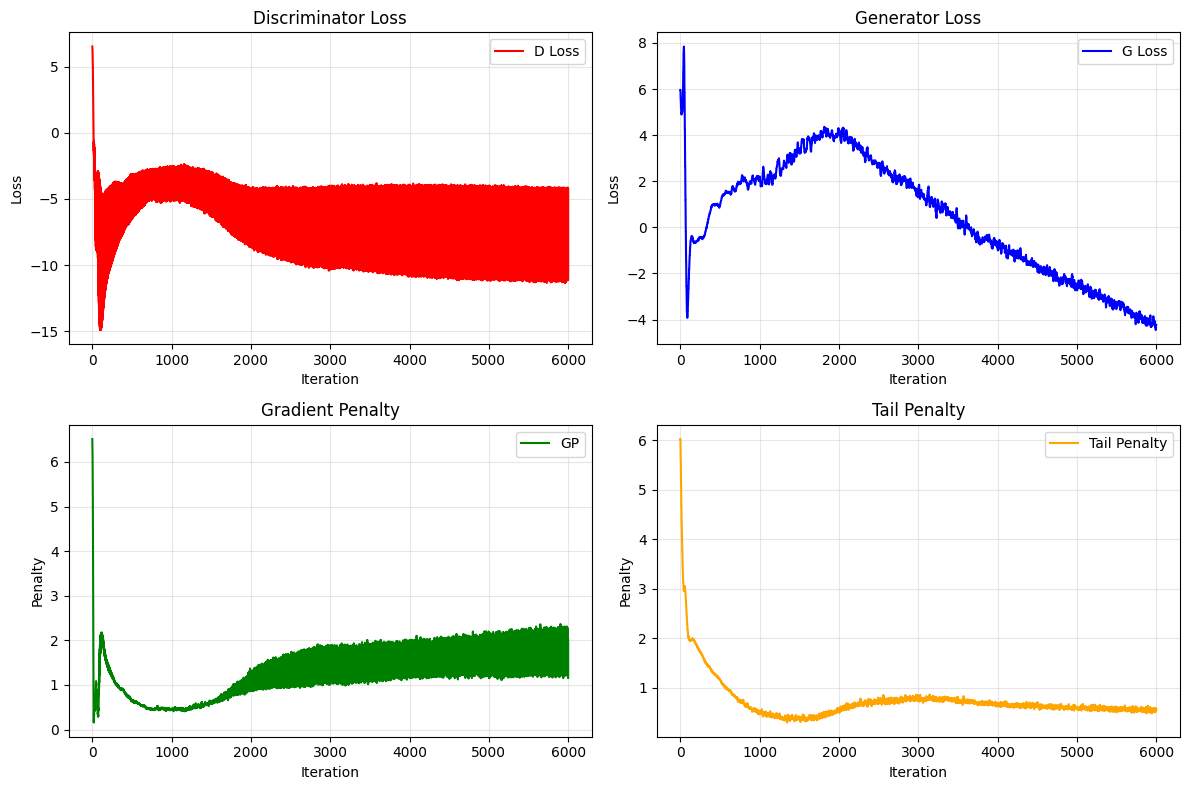

Training GANs: 100%|██████████| 1/1 [01:55<00:00, 115.15s/asset]

Finished training GAN for HY.

Generated scenarios saved to: generated_CGAN_output_test/generated_returns_HY_final_scenarios.pt
Finished generating scenarios for HY.

HY: Stored initial generated scenarios for 2019-01-02 00:00:00.


In [9]:
# Dictionary to store generated scenarios by asset and date.
# Structure: { asset_name: { date: generated_scenarios, ... }, ... }
scenarios_results = {}

for asset_name in tqdm(returns_df.columns, desc="Training GANs", unit="asset"):
    print(f"Training GAN for {asset_name}...")
    asset_returns = returns_df[asset_name]
    eonia_returns = returns_df_full['EONIA']

    if asset_name in ['IG', 'HY', 'GOV']:
        ## SEE HERE
          #---------------------------------------------------------------------------------------------
          gan = BondGAN(asset_returns, asset_name, n_epochs=3000, lambda_gp =7, lag_periods=[14,90,180], cond_scale=0.01, lambda_skew = 0, lambda_kurtosis=0)
          gan.g_lr = 10e-6
          gan.d_lr = 50e-8

          #---------------------------------------------------------------------------------------------

    ## NOT BELOW

    elif asset_name == 'EONIA':
        gan = shortRateGAN(asset_returns, asset_name, n_epochs=1200, lambda_gp = 7, cond_scale=0.2)
        gan.g_lr = 10e-7
        gan.d_lr = 50e-8
    else:
        #        gan = LambardGAN(asset_returns, asset_name, n_epochs=10000,
                         #lambda_gp = 2, lambda_tail=5, lag_periods=[252, 500, 700], cond_scale=0.6)
        gan = LambardGAN(asset_returns, asset_name, n_epochs=6000,
                         lambda_gp = 2, lambda_tail=5, lag_periods=[252, 500, 700], cond_scale=0.25)
        gan.g_lr = 10e-6
        gan.d_lr = 10e-7

    gan.train()
    print(f"Finished training GAN for {asset_name}.\n")

    scenarios = gan.generate_scenarios(num_scenarios=4000)
    print(f"Finished generating scenarios for {asset_name}.\n")

    gan_dict[asset_name] = gan

    initial_date = returns_df.index[-1]
    next_day = initial_date + pd.Timedelta(days=1)
    scenarios_results.setdefault(asset_name, {})[next_day] = scenarios
    print(f"{asset_name}: Stored initial generated scenarios for {initial_date}.")

In [14]:
df = pd.DataFrame({'d_losses': gan.d_losses})
df.to_csv('/content/drive/MyDrive/MasterThesis/d_losses/hy.csv', index=False)

print("Saved to /content/drive/MyDrive/MasterThesis/d_losses/hy.csv")

Saved to /content/drive/MyDrive/MasterThesis/d_losses/hy.csv


In [11]:
def load_gan_model(asset_name, model_class, num):
    model_path = f"/content/drive/MyDrive/gan_models_{num}/{asset_name}_gan.pt"
    checkpoint = torch.load(model_path, weights_only=False)

    dummy_returns = returns_df[asset_name]

    if asset_name in ['IG', 'HY', 'GOV']:
        gan = model_class(dummy_returns, asset_name, n_epochs=1000, lambda_gp =7, cond_scale=1)
        gan.g_lr = 10e-6
        gan.d_lr = 50e-8

    elif asset_name == 'EONIA':
        gan = model_class(dummy_returns, asset_name, n_epochs=1200, lambda_gp = 7, cond_scale=1)
        gan.g_lr = 10e-7
        gan.d_lr = 50e-8
    else:
        gan = model_class(dummy_returns, asset_name, n_epochs=3000,
                         lambda_gp = 2, lambda_tail=5, lag_periods=[252, 500, 700], cond_scale=0.35)
        gan.g_lr = 10e-6
        gan.d_lr = 10e-7

    gan.setup()

    # Load saved weights and scalers
    gan.generator.load_state_dict(checkpoint['generator'])
    gan.generator.eval()
    gan.discriminator.load_state_dict(checkpoint['discriminator'])
    gan.discriminator.eval()
    #gan.scaler = checkpoint['scaler']
    #gan.condition_scaler = checkpoint['condition_scaler']

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    gan.generator.to(device)
    gan.discriminator.to(device)
    gan.cuda = torch.cuda.is_available()

    return gan



'''
for asset_name in returns_df.columns:
    print(asset_name)
    if asset_name in ['IG', 'HY', 'GOV']:
        gan_dict[asset_name] = load_gan_model(asset_name, BondGAN, 2)
    elif asset_name == 'EONIA':
        gan_dict[asset_name] = load_gan_model(asset_name, shortRateGAN, 2)
    else:
      continue
      gan_dict[asset_name] = load_gan_model(asset_name, LambardGAN, 1)

'''



"\nfor asset_name in returns_df.columns:\n    print(asset_name)\n    if asset_name in ['IG', 'HY', 'GOV']:\n        gan_dict[asset_name] = load_gan_model(asset_name, BondGAN, 2)\n    elif asset_name == 'EONIA':\n        gan_dict[asset_name] = load_gan_model(asset_name, shortRateGAN, 2)\n    else:\n      continue\n      gan_dict[asset_name] = load_gan_model(asset_name, LambardGAN, 1)\n\n"

In [12]:
# Prelimenary  For reseting

for asset_name in gan_dict:
    gan_dict[asset_name].returns_series = returns_df[asset_name]

In [13]:
all_dates = []

for asset_name in test_returns_df.columns:
    asset_returns = returns_df[asset_name]
    gan = gan_dict[asset_name]
    foundNAN = False
    print("Asset =", asset_name)

    i = 0
    for test_day in tqdm(test_returns_df.index[:-252], desc="Processing Dates", unit="dates"):
        i += 1
        new_return = test_returns_df.loc[test_day, asset_name]

        if test_day != test_returns_df.index[-1]:
            next_day = test_returns_df.index[test_returns_df.index.get_loc(test_day) + 1]
        else:
            print(f"Warning: {test_day} is the last day in the index, no next day available.")
            continue

        # next eonia

        new_eonia_return = test_returns_df_full.loc[test_day, 'EONIA']

        #gan.update_eonia(new_eonia_return, next_day)
        scenarios = gan.generate_new_scenarios_from_return(new_return, test_day, 1, next_day, save=True, num_scenarios=10000)

        has_inf = np.isinf(scenarios).any()
        has_nan = np.isnan(scenarios).any()

        if has_nan or has_inf:
            print("FOUND NAN")
            foundNAN = True
            break
        all_dates.append(next_day)

    if foundNAN: break

Asset = HY


Processing Dates:  18%|█▊        | 218/1232 [00:09<00:46, 21.84dates/s]


KeyboardInterrupt: 

## Making sure the window ends when we want to start testing

In [ ]:
entire_df = pd.concat([returns_df, test_returns_df])

'''
test_start_date = '2020-01-01'
test_start_date = pd.to_datetime(test_start_date)

test_end_date = test_returns_df.index.max()
print("Test end date:", test_end_date)

# Find the index location of the test_start_date in entire_df
idx = entire_df.index.get_loc(test_end_date)
idx_start = entire_df.index.get_loc(test_start_date)
'''

# Slice 252 rows before that index
historical_df = test_returns_df
historical_df.head()

In [ ]:
# CALCULATE DELTA BOF ARRAY
eonia = historical_df.iloc[:, -1]
bof_0 = assets_0 - liabilities_0

In [ ]:
n_windows = len(historical_df) - 252 + 1

window_start_dates = []
window_end_dates = []
realized_bof_values = []
realized_delta_bof_values_1 = []

for t in range(n_windows):
    # Get window data
    window_data = historical_df.iloc[t:t+252]
    window_start_date = historical_df.index[t]
    window_end_date = historical_df.index[t+252-1]

    # Get returns and EONIA for this window
    window_returns = (window_data).sum(axis=1)
    window_eonia = window_data.iloc[:, -1]

    # Calculate portfolio value at the end of the window
    # Starting from assets_0 each time
    portfolio_value_end = assets_0 * (1 + window_returns).prod() # This is analogous to the yearly return

    # Calculate liabilities at the end of the window
    # Starting from liabilities_0 each time
    liabilities_end = liabilities_0 * (1 + window_eonia).prod()

    # Calculate BOF at the end of the window
    bof_end = portfolio_value_end - liabilities_end
    delta_bof = bof_end - bof_0

    # Store results
    window_start_dates.append(window_start_date)
    window_end_dates.append(window_end_date)
    realized_bof_values.append(bof_end)
    realized_delta_bof_values_1.append(portfolio_value_end)

## Does not work, since when we have a rolling BOF_0, and windows are overlapping, returns are counted over again multiple times, hence blowing up bof_0

To mitigate these i look at portfolio and liability values on a daily basis. I check the start and end values for all the different windows.

In [ ]:
import concurrent.futures
from functools import partial
from tqdm import tqdm


def process_date(date, asset_names, device="cuda"):
    gan_samples_cols = []
    for asset in asset_names:
        file_path = os.path.join(f"test_{date}", f"generated_returns_{asset}_scenarios.pt")
        asset_scenarios = torch.load(file_path, map_location=device).double()
        asset_cum = torch.prod(1 + asset_scenarios, dim=1) - 1
        gan_samples_cols.append(asset_cum.reshape(-1, 1))

    gan_samples = torch.cat(gan_samples_cols, dim=1)


    # Calculate VaR
    cumulative_returns = torch.prod(1 + gan_samples, dim=1) - 1  # Shape: (N,)

    final_asset_values = assets_0 * (1 + cumulative_returns)

    var = torch.quantile(final_asset_values, 0.005)




    if var > 1e6:
        var = 1e6


    return date, var


asset_names = list(returns_df.columns)
all_dates = set(all_dates)
all_dates = sorted(all_dates)

portfolio_scr_results = {}
for date in tqdm(all_dates, desc="Processing dates with GPU"):
    date, scr = process_date(date, asset_names=asset_names)
    portfolio_scr_results[date] = scr

In [ ]:
sorted_dates = sorted(portfolio_scr_results.keys())
scr_values = [portfolio_scr_results[date].cpu() if hasattr(portfolio_scr_results[date], 'cpu') else portfolio_scr_results[date] for date in sorted_dates]

plt.figure(figsize=(18, 3))
plt.plot(scr_values, linestyle='-')
plt.xlabel("Windows")
plt.ylabel("VaR")
plt.title("Portfolio SCR Over Time")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
1232/200

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(scr_values, linestyle='-', label='SCR')
plt.plot(realized_delta_bof_values_1, linestyle='-', label='Realized Delta BOF')


plt.xlabel("Window")
plt.ylabel("Assets")
plt.title("VaR v.s. Actual")
plt.grid(False)
plt.tight_layout()
plt.legend()
plt.show()

exceedances = sum(scr > realized for scr, realized in zip(scr_values, realized_delta_bof_values_1))
print(f"SCR exceeds realized: {exceedances} times out of {len(scr_values)}")

count = 0
for i in range(len(scr_values)):

    if scr_values[i] > realized_delta_bof_values_1[i]:
      count += 1
      print("Window =", i+ 1)

In [ ]:
save_dir = '/content/drive/MyDrive/gan_models_1'
scenarios_dir = '/content/drive/MyDrive/gan_scenarios'
os.makedirs(save_dir, exist_ok=True)
os.makedirs(scenarios_dir, exist_ok=True)

'''
# Save GAN models
for asset_name, gan in gan_dict.items():
    model_path = f"{save_dir}/{asset_name}_gan.pt"
    torch.save({
        'generator': gan.generator.state_dict(),
        'discriminator': gan.discriminator.state_dict(),
        'scaler': gan.scaler,
        'condition_scaler': gan.condition_scaler
    }, model_path)

print(f"Saved {len(gan_dict)} models to {save_dir}")
'''


In [ ]:
x_scr_shifted = range(-252, len(scr_values) - 252)
plt.figure(figsize=(10, 6))
plt.plot(x_scr_shifted, scr_values, linestyle='-', label='SCR (shifted)')

# Plot realized_delta_bof_values_1 (assuming its x-values start from 0)
plt.plot(realized_delta_bof_values_1, linestyle='-', label='Realized Delta BOF')

plt.xlabel("Window")
plt.ylabel("Assets")
plt.title("VaR")
plt.grid(False)
plt.tight_layout()
plt.legend()
plt.show()

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## SHOWING A BUNCH OF GAN SPESIFIC RESULTS

- Distributions
- Latent space plots
- PCAs

etc.

In [ ]:
for asset_name in returns_df.columns:
    print(asset_name)
    if asset_name in ['IG', 'HY', 'EONIA']:
        gan_dict[asset_name].generate_scenarios(num_scenarios=4000)
    else:
      gan_dict[asset_name].generate_scenarios(num_scenarios=4000)

# ----------------------------------------------------------

In [ ]:
extensive_plotting(scaled=False, returns_df=returns_df, test=True, quarterly=False)

In [ ]:

# Save GAN models
for asset_name, gan in gan_dict.items():
    model_path = f"{save_dir}/{asset_name}_gan.pt"
    torch.save({
        'generator': gan.generator.state_dict(),
        'discriminator': gan.discriminator.state_dict(),
        'scaler': gan.scaler,
        'condition_scaler': gan.condition_scaler
    }, model_path)

print(f"Saved {len(gan_dict)} models to {save_dir}")

In [ ]:
import shap
import numpy as np
import torch

def gan_shap(gan, n_samples=20):
    """Memory-efficient SHAP analysis for GAN conditions -> generated mean returns"""

    def predict_mean(conditions):
        device = next(gan.generator.parameters()).device
        results = []

        # Process one condition at a time to save memory
        for cond in conditions:
            z = torch.randn(50, gan.latent_dim, device=device)  # Reduced from 100 to 50
            cond_batch = np.tile(cond, (50, 1))
            cond_tensor = torch.tensor(cond_batch, dtype=torch.float32, device=device)

            with torch.no_grad():
                gen_returns = gan.generator(z, cond_tensor)
                gen_returns = gan.scaler.inverse_transform(gen_returns.cpu().numpy())
                results.append(gen_returns.mean())

            # Clear GPU cache
            del z, cond_tensor, gen_returns
            torch.cuda.empty_cache()

        return np.array(results)

    # Sample data
    idx = np.random.choice(len(gan.conditions), n_samples, replace=False)
    X = gan.conditions[idx]

    # Create feature names
    feature_names = []
    for lag in gan.lag_periods:
        feature_names.extend([
            f'cum_return_{lag}d',
            f'volatility_{lag}d',
            f'kurtosis_{lag}d',
            f'max_drawdown_{lag}d'
        ])

    # SHAP with smaller samples
    explainer = shap.KernelExplainer(predict_mean, X[:10])
    shap_values = explainer.shap_values(X[:10])

    # Plot with feature names
    shap.summary_plot(shap_values, X[:10], feature_names=feature_names, show=True)

    return shap_values

for name in gan_dict:
    gan_shap(gan_dict[name])

In [ ]:

# Save GAN models
for asset_name, gan in gan_dict.items():
    model_path = f"{save_dir}/{asset_name}_gan.pt"
    torch.save({
        'generator': gan.generator.state_dict(),
        'discriminator': gan.discriminator.state_dict(),
        'scaler': gan.scaler,
        'condition_scaler': gan.condition_scaler
    }, model_path)

print(f"Saved {len(gan_dict)} models to {save_dir}")
